In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the data
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_regular_season_data_2.csv')
print(data_path)
data = pd.read_csv(data_path)

/workspaces/Wharton-HS-Competition-Soccer-Playoff-Predictions/data/NSL_regular_season_data_2.csv


In [2]:
# Visualize the data
data

,game_id,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP
0,game_2023_94,TUC,ALB,1,3,2.52,2.00,13,15,3,4,0,0,1,0,0.53
1,game_2023_341,MOB,ALB,3,1,0.46,0.99,11,8,3,6,0,0,0,0,0.56
2,game_2023_442,CHM,ALB,0,1,1.62,1.16,16,13,1,7,0,0,0,0,0.52
3,game_2023_50,SAS,ALB,2,1,1.53,0.55,20,2,6,1,0,0,0,0,0.49
4,game_2023_389,FOR,ALB,0,2,2.15,1.13,18,13,2,0,0,0,0,0,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,game_2023_81,TUC,WIC,2,1,2.72,0.38,16,8,8,2,0,0,0,0,0.33
472,game_2023_36,DOV,WIC,0,2,1.11,1.34,9,13,7,4,0,0,0,0,0.31
473,game_2023_269,SFS,WIC,1,1,2.84,0.30,26,2,8,6,0,0,0,0,0.54
474,game_2023_298,ALB,WIC,2,3,2.61,2.09,12,17,7,4,0,0,0,0,0.43


In [3]:
# Create mean goals scored as home and away.
data['HomeMeanGoals'] = data['HomeScore'].groupby(data['HomeTeam']).transform('mean')
data['AwayMeanGoals'] = data['AwayScore'].groupby(data['AwayTeam']).transform('mean')

# Calculate the win percentage of the home team. 1 = win, 0 = loss, 0.5 = tie.
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_rankings.csv')
rankings = pd.read_csv(data_path)

# Look up the win percentage of the home team in the rankings table.
data['HomeWinPct'] = data['HomeTeam'].map(rankings.set_index('Team')['WinPct'])
data['AwayWinPct'] = data['AwayTeam'].map(rankings.set_index('Team')['WinPct'])

# Create a new column called 'Winner' that contains 1 if team wins, 0 if team loses. If tie, use mean goals to determine winner.
data['Winner'] = np.where(data['HomeScore'] > data['AwayScore'], 1, 0)
# data['Winner'] = np.where(data['HomeScore'] < data['AwayScore'], 0, data['Winner'])
data['Winner'] = np.where(data['HomeScore'] == data['AwayScore'], np.where(data['HomeWinPct'] > data['AwayWinPct'], 1, 0), data['Winner'])
data['Winner'] = data['Winner'].astype(int)

data

,game_id,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,...,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,HomeMeanGoals,AwayMeanGoals,HomeWinPct,AwayWinPct,Winner
0,game_2023_94,TUC,ALB,1,3,2.52,2.00,13,15,3,...,0,0,1,0,0.53,1.705882,1.764706,0.264706,0.264706,0
1,game_2023_341,MOB,ALB,3,1,0.46,0.99,11,8,3,...,0,0,0,0,0.56,1.058824,1.764706,0.294118,0.264706,1
2,game_2023_442,CHM,ALB,0,1,1.62,1.16,16,13,1,...,0,0,0,0,0.52,0.882353,1.764706,0.264706,0.264706,0
3,game_2023_50,SAS,ALB,2,1,1.53,0.55,20,2,6,...,0,0,0,0,0.49,1.352941,1.764706,0.411765,0.264706,1
4,game_2023_389,FOR,ALB,0,2,2.15,1.13,18,13,2,...,0,0,0,0,0.71,1.764706,1.764706,0.352941,0.264706,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,game_2023_81,TUC,WIC,2,1,2.72,0.38,16,8,8,...,0,0,0,0,0.33,1.705882,1.294118,0.264706,0.235294,1
472,game_2023_36,DOV,WIC,0,2,1.11,1.34,9,13,7,...,0,0,0,0,0.31,1.941176,1.294118,0.411765,0.235294,0
473,game_2023_269,SFS,WIC,1,1,2.84,0.30,26,2,8,...,0,0,0,0,0.54,1.647059,1.294118,0.441176,0.235294,1
474,game_2023_298,ALB,WIC,2,3,2.61,2.09,12,17,7,...,0,0,0,0,0.43,1.470588,1.294118,0.264706,0.235294,0


In [4]:
# Drop the HomeMeanGoals and AwayMeanGoals columns.
data.drop(['HomeMeanGoals', 'AwayMeanGoals'], axis=1, inplace=True)

# Drop the HomeWinPct and AwayWinPct columns.
data.drop(['HomeWinPct', 'AwayWinPct'], axis=1, inplace=True)

# Create a date column from the matches.
data['GameNumber'] = data['game_id'].str.split('_', expand=True)[2]
data['GameNumber'] = data['GameNumber'].astype(int)
data.drop('game_id', axis=1, inplace=True)
data.sort_values(by='GameNumber', inplace=True)
data.reset_index(drop=True, inplace=True)

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


In [5]:
team_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_Metadata.csv'))
team_data.head()

,name,city,state,Team_ID,conference,timezone_UTC,Unnamed: 6
0,Albuquerque Scorpions FC,Albuquerque,New Mexico,ALB,Western,-6,NaN
1,Anchorage Avalanche FC,Anchorage,Alaska,ANC,Western,-8,NaN
2,Augusta Arrows FC,Augusta,Georgia,AUG,Eastern,-4,NaN
3,Bakersfield Bandits FC,Bakersfield,California,BAK,Western,-7,NaN
4,Boise Thunderhawks FC,Boise,Idaho,BOI,Western,-6,NaN


In [6]:
# Perform one-hot encoding on the 'HomeTeam' and 'AwayTeam' columns.
# If the team is the home team, the column will be 2, else 1.
# for team in team_data['Team_ID']:
#     data[team] = (data['HomeTeam'] == team) * 2 + (data['AwayTeam'] == team)
#     data[team] = data[team].astype(int)

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


Text(0, 0.5, 'Frequency')

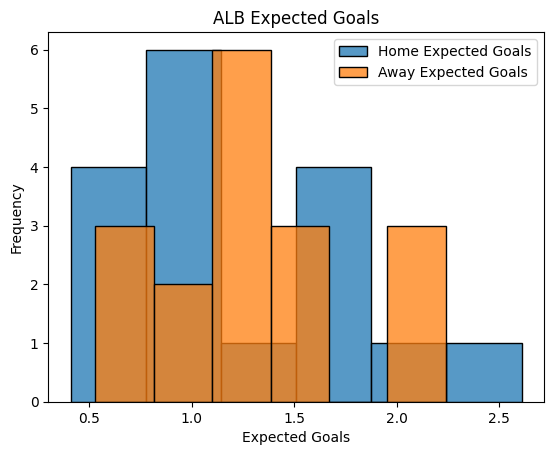

In [7]:
# See if the expected goals for a certain team follows a trend.
rand_team = random.choice(team_data['Team_ID'])
# Make two distributions for the home and away scores
home_scores = data[data['HomeTeam'] == rand_team]['Home_xG']
away_scores = data[data['AwayTeam'] == rand_team]['Away_xG']
# Plot the distributions
sns.histplot(home_scores, label='Home Expected Goals')
sns.histplot(away_scores, label='Away Expected Goals')
plt.legend(loc=1)
plt.title(f'{rand_team} Expected Goals')
plt.xlabel('Expected Goals')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Accuracy: 0.64')

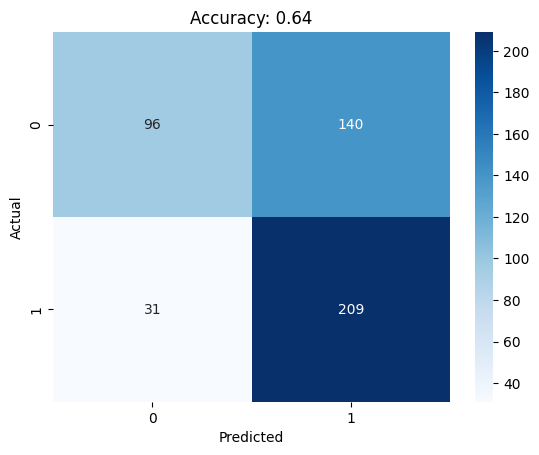

In [8]:
# See how good the expected goals are at predicting the winner of a match.
expected_winner = data['Home_xG'] > data['Away_xG']
winner = data['Winner']

accuracy = (expected_winner == winner).sum() / len(winner)
conf_matrix = confusion_matrix(winner, expected_winner)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Accuracy: {accuracy:.2f}')

In [9]:
# See if the time since the last game (either as home or away) has an effect on the outcome of the game.
# Create a new column that contains the time since the last game for the home and away teams.
# If the team has not played a game yet, the time since the last game will be 0.
# For each row, the time since the last game will be the difference between the current game number and the previous game number (whether the last game was home or away).
# for game in data['GameNumber']:
#     home_team = data[data['GameNumber'] == game]['HomeTeam'].values[0]
#     away_team = data[data['GameNumber'] == game]['AwayTeam'].values[0]
#     # Find the time since the last game for the home and away teams
#     home_last_games = data[(data['HomeTeam'] == home_team) | (data['AwayTeam'] == home_team)]['GameNumber']
#     away_last_games = data[(data['HomeTeam'] == away_team) | (data['AwayTeam'] == away_team)]['GameNumber']
#     home_last_game = game - home_last_games[home_last_games < game].max() if len(home_last_games[home_last_games < game]) > 0 else 0
#     away_last_game = game - away_last_games[away_last_games < game].max() if len(away_last_games[away_last_games < game]) > 0 else 0
#     data.loc[data['GameNumber'] == game, 'HomeLastGame'] = home_last_game # Last Time Home Team Played at all
#     data.loc[data['GameNumber'] == game, 'AwayLastGame'] = away_last_game # Last Time Away Team Played at all

# data['HomeLastGame'] = data.groupby('HomeTeam')['GameNumber'].diff().fillna(0) # Last Time Home Team Played as Home Team
# data['AwayLastGame'] = data.groupby('AwayTeam')['GameNumber'].diff().fillna(0) # Last Time Away Team Played as Away Team
# data['HomeLastGame'] = data['HomeLastGame'].astype(int)
# data['AwayLastGame'] = data['AwayLastGame'].astype(int)

# # Plot the distributions of the time since the last game for the home and away teams.
# sns.histplot(data['HomeLastGame'], label='Home Last Game')
# sns.histplot(data['AwayLastGame'], label='Away Last Game')
# plt.legend(loc=1)
# plt.title('Time Since Last Game')
# plt.xlabel('Games Since Last Game')
# plt.ylabel('Frequency')

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


In [10]:
# Does morale (current win streak) have an effect on the outcome of the game?
# Create a new column that contains the current win streak for the home and away teams.
# Reset the win streak for each team when the team loses.
# data['HomeWins'] = -1
# data['AwayWins'] = -1
# home_win_streaks = []
# away_win_streaks = []

# for game in data['GameNumber']:
#     print('Game Number', game)
#     home_team = data[data['GameNumber'] == game]['HomeTeam'].values[0]
#     away_team = data[data['GameNumber'] == game]['AwayTeam'].values[0]
#     # Find the current win streak for the home and away teams
#     home_games_for_home = data[(data['HomeTeam'] == home_team) & (data['GameNumber'] < game)]['Winner']
#     away_games_for_home = 1 - data[(data['AwayTeam'] == home_team) & (data['GameNumber'] < game)]['Winner']
#     home_wins_for_home = home_games_for_home.sum()
#     away_wins_for_home = away_games_for_home.sum()

#     home_games_for_away = data[(data['HomeTeam'] == away_team) & (data['GameNumber'] < game)]['Winner']
#     away_games_for_away = 1 - data[(data['AwayTeam'] == away_team) & (data['GameNumber'] < game)]['Winner']
#     home_wins_for_away = home_games_for_away.sum()
#     away_wins_for_away = away_games_for_away.sum()
#     data.loc[data['GameNumber'] == game, 'HomeWins'] = home_wins_for_home + away_wins_for_home
#     data.loc[data['GameNumber'] == game, 'AwayWins'] = home_wins_for_away + away_wins_for_away
#     # Reset the win streak for each team when the team loses
#     games_for_home = home_games_for_home.append(away_games_for_home)
#     games_for_away = home_games_for_away.append(away_games_for_away)
#     # Sort the games in descending order
#     games_for_home.sort_index(ascending=False, inplace=True)
#     games_for_away.sort_index(ascending=False, inplace=True)
#     # Find the current win streak for the home and away teams
#     home_win_streak = 0
#     away_win_streak = 0
#     for game in games_for_home:
#         if game:
#             home_win_streak += 1
#             print(home_win_streak)
#         else:
#             print('Done Home', home_win_streak)
#             break
#     for game in games_for_away:
#         if game:
#             away_win_streak += 1
#             print(away_win_streak)
#         else:
#             print('Done Away', away_win_streak)
#             break
#     home_win_streaks.append(home_win_streak)
#     away_win_streaks.append(away_win_streak)
#     print()

# data['HomeWinStreak'] = home_win_streaks
# data['AwayWinStreak'] = away_win_streaks

# data['HomeWins'] = data['HomeWins'].astype(int)
# data['AwayWins'] = data['AwayWins'].astype(int)
# data['HomeWinStreak'] = data['HomeWinStreak'].astype(int)
# data['AwayWinStreak'] = data['AwayWinStreak'].astype(int)

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,1,1,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1,0,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1,2,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,0,1,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,0,0,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1,2,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1,1,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,3,2,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1,2,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


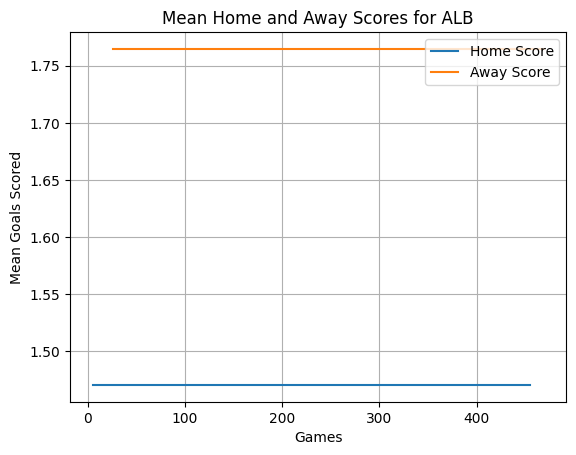

In [11]:
# Target encode the scores. Average number of goals scored by the home team and away team.
# If the means for the same team for home and away are different, then being at home or away has an effect on the score.
data['HomeScore'] = data.groupby('HomeTeam')['HomeScore'].transform('mean')
data['AwayScore'] = data.groupby('AwayTeam')['AwayScore'].transform('mean')

# Compare the means of the scores for the home and away teams
rand_team = random.choice(team_data['Team_ID'])
plt.plot(data[data['HomeTeam'] == rand_team]['HomeScore'], label='Home Score')
plt.plot(data[data['AwayTeam'] == rand_team]['AwayScore'], label='Away Score')
plt.xlabel('Games')
plt.ylabel('Mean Goals Scored')
plt.grid()
plt.title(f'Mean Home and Away Scores for {rand_team}')
plt.legend(loc=1)


In [12]:
# Drop the 'HomeTeam' and 'AwayTeam' columns
# data.drop(['HomeTeam', 'AwayTeam'], axis=1, inplace=True)

data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,Winner,GameNumber
0,PRO,MAN,2.000000,0.941176,1.63,0.34,17,8,5,4,0,0,0,0,0.53,1,1
1,FOR,LEX,1.764706,1.352941,0.98,0.90,9,11,5,2,0,0,0,0,0.57,1,2
2,SJU,DES,1.470588,1.647059,1.23,1.11,16,9,6,7,0,0,0,0,0.47,0,3
3,FAR,ANC,2.058824,2.117647,2.27,1.08,4,14,8,3,0,0,0,0,0.51,0,4
4,DOV,BAK,1.941176,1.352941,1.90,0.56,17,6,5,3,0,0,0,0,0.53,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,SAS,TAC,1.352941,1.235294,0.71,0.51,19,12,7,7,0,0,0,0,0.42,0,472
472,DOV,MOB,1.941176,1.235294,1.70,0.14,19,10,1,5,0,0,0,0,0.51,1,473
473,BAK,EUG,1.411765,1.470588,2.68,1.43,17,18,9,6,1,0,2,1,0.49,1,474
474,LRO,LEX,1.470588,1.352941,2.10,1.30,17,6,5,5,0,0,0,0,0.51,0,475


/tmp/ipykernel_33047/4230324319.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot: >

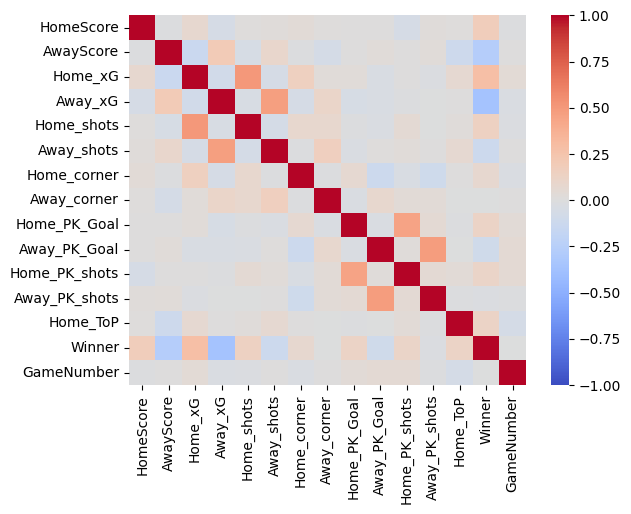

In [13]:
# Find what features are most correlated with the winner
corr = data.corr()

# Create a heatmap
# Set the colorbar limits to be between -1 and 1
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)

In [14]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(data, target = 'Winner', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Winner
2,Target type,Binary
3,Original data shape,"(476, 17)"
4,Transformed data shape,"(476, 17)"
5,Transformed train set shape,"(333, 17)"
6,Transformed test set shape,"(143, 17)"
7,Numeric features,14
8,Categorical features,2
9,Preprocess,True


In [15]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7019,0.0000,0.6787,0.7151,0.6936,0.4041,0.4071,0.0670
lr,Logistic Regression,0.6900,0.7663,0.6967,0.6886,0.6893,0.3809,0.3841,0.6160
rf,Random Forest Classifier,0.6782,0.7324,0.6790,0.6863,0.6779,0.3563,0.3621,0.2040
et,Extra Trees Classifier,0.6689,0.7236,0.6482,0.6781,0.6573,0.3379,0.3445,0.1870
catboost,CatBoost Classifier,0.6661,0.7337,0.6551,0.6745,0.6623,0.3326,0.3352,1.4890
gbc,Gradient Boosting Classifier,0.6658,0.7140,0.6610,0.6709,0.6613,0.3320,0.3361,0.1380
lda,Linear Discriminant Analysis,0.6658,0.7422,0.6904,0.6634,0.6731,0.3315,0.3366,0.0670
nb,Naive Bayes,0.6578,0.7622,0.7438,0.6544,0.6876,0.3141,0.3282,0.0710
xgboost,Extreme Gradient Boosting,0.6538,0.6985,0.6489,0.6551,0.6482,0.3086,0.3115,0.1130
ada,Ada Boost Classifier,0.6482,0.7056,0.6426,0.6534,0.6443,0.2961,0.2998,0.1500


In [16]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
s.save_model(best, 'best_feature_engineering_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HomeScore', 'AwayScore',
                                              'Home_xG', 'Away_xG', 'Home_shots',
                                              'Away_shots', 'Home_corner',
                                              'Away_corner', 'Home_PK_Goal',
                                              'Away_PK_Goal', 'Home_PK_shots',
                                              'Away_PK_shots', 'Home_ToP',
                                              'GameNumber'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fi...
                                     transformer=TargetEncoder(cols=['HomeTeam',
                                         

In [18]:
# Load the group stage game data
group_stage_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_Group_Round_Games.csv'))
group_stage_data

,game_id,HomeTeam,AwayTeam
0,Group1_Game1,ANC,LEX
1,Group1_Game2,DOV,TAC
2,Group1_Game3,TAC,ANC
3,Group1_Game4,DOV,LEX
4,Group1_Game5,ANC,DOV
5,Group1_Game6,LEX,TAC
6,Group2_Game1,FAR,TOL
7,Group2_Game2,SPR,TUC
8,Group2_Game3,TUC,FAR
9,Group2_Game4,SPR,TOL


In [19]:
# Derive the game number from the game_id
group_stage_data['GameNumber'] = group_stage_data['game_id'].str.split('_', expand=True)[1]
# Get the game number as an integer when GameNumber (Game1)
group_stage_data['GameNumber'] = group_stage_data['GameNumber'].str.extract('(\d+)').astype(int)
group_stage_data['GameNumber'] = group_stage_data['GameNumber'].astype(int)
group_stage_data.drop('game_id', axis=1, inplace=True)
group_stage_data

,HomeTeam,AwayTeam,GameNumber
0,ANC,LEX,1
1,DOV,TAC,2
2,TAC,ANC,3
3,DOV,LEX,4
4,ANC,DOV,5
5,LEX,TAC,6
6,FAR,TOL,1
7,SPR,TUC,2
8,TUC,FAR,3
9,SPR,TOL,4


In [20]:
# Find the home and away expected goals for each game based on the average expected goals for the home and away teams in the regular season.
group_stage_data['Home_xG'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_xG'].mean())
group_stage_data['Away_xG'] = group_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_xG'].mean())

# Find the home and away shots
group_stage_data['Home_shots'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_shots'].mean())
group_stage_data['Away_shots'] = group_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_shots'].mean())

In [21]:
# Find the home_corners and away_corners
group_stage_data['Home_corner'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_corner'].mean())
group_stage_data['Away_corner'] = group_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_corner'].mean())

# Find the home and away PK Goals
group_stage_data['Home_PK_Goal'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_PK_Goal'].mean())
group_stage_data['Away_PK_Goal'] = group_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_PK_Goal'].mean())

# Find the home and way PK shots
group_stage_data['Home_PK_shots'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_PK_shots'].mean())
group_stage_data['Away_PK_shots'] = group_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_PK_shots'].mean())

# Find the Home_ToP
group_stage_data['Home_ToP'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_ToP'].mean())

# Calculate the HomeScore and AwayScore columns based on the average scores for the home and away teams in the regular season.
group_stage_data['HomeScore'] = group_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['HomeScore'].mean())
group_stage_data['AwayScore'] = group_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['AwayScore'].mean())

# Reorder the columns to be in the same order as the regular season data
col_order = list(data.columns)
col_order.remove('Winner')
# print(col_order)
group_stage_data = group_stage_data[col_order]

group_stage_data



,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,GameNumber
0,ANC,LEX,1.411765,1.352941,2.084118,1.075294,17.882353,11.352941,5.352941,4.294118,0.000000,0.000000,0.235294,0.058824,0.480000,1
1,DOV,TAC,1.941176,1.235294,1.835294,0.737647,17.058824,10.117647,5.058824,4.411765,0.000000,0.000000,0.235294,0.176471,0.469412,2
2,TAC,ANC,1.705882,2.117647,1.447647,1.014118,15.470588,12.000000,5.176471,3.882353,0.058824,0.000000,0.176471,0.058824,0.525882,3
3,DOV,LEX,1.941176,1.352941,1.835294,1.075294,17.058824,11.352941,5.058824,4.294118,0.000000,0.000000,0.235294,0.058824,0.469412,4
4,ANC,DOV,1.411765,1.705882,2.084118,1.110588,17.882353,13.470588,5.352941,4.117647,0.000000,0.058824,0.235294,0.117647,0.480000,5
5,LEX,TAC,1.647059,1.235294,1.578235,0.737647,16.411765,10.117647,5.941176,4.411765,0.000000,0.000000,0.235294,0.176471,0.478235,6
6,FAR,TOL,2.058824,1.294118,2.027647,0.973529,14.764706,10.705882,7.294118,4.764706,0.000000,0.000000,0.176471,0.117647,0.550000,1
7,SPR,TUC,2.294118,1.176471,1.267059,0.747647,14.117647,10.411765,4.941176,5.117647,0.058824,0.117647,0.294118,0.117647,0.467059,2
8,TUC,FAR,1.705882,1.941176,1.681765,1.147059,13.823529,11.470588,5.117647,3.588235,0.058824,0.058824,0.235294,0.117647,0.498824,3
9,SPR,TOL,2.294118,1.294118,1.267059,0.973529,14.117647,10.705882,4.941176,4.764706,0.058824,0.000000,0.294118,0.117647,0.467059,4


In [22]:
# Use the model to predict the winners of the group stage games
playoff_results = s.predict_model(best, data=group_stage_data, raw_score=True)

# Predicted Winner
playoff_results['Predicted_Winner'] = np.where(playoff_results['prediction_label'], playoff_results['HomeTeam'], playoff_results['AwayTeam'])

playoff_results

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,GameNumber,prediction_label,Predicted_Winner
0,ANC,LEX,1.411765,1.352941,2.084118,1.075294,17.882353,11.352942,5.352941,4.294117,0.000000,0.000000,0.235294,0.058824,0.480000,1,1,ANC
1,DOV,TAC,1.941176,1.235294,1.835294,0.737647,17.058823,10.117647,5.058824,4.411765,0.000000,0.000000,0.235294,0.176471,0.469412,2,1,DOV
2,TAC,ANC,1.705882,2.117647,1.447647,1.014118,15.470589,12.000000,5.176471,3.882353,0.058824,0.000000,0.176471,0.058824,0.525882,3,0,ANC
3,DOV,LEX,1.941176,1.352941,1.835294,1.075294,17.058823,11.352942,5.058824,4.294117,0.000000,0.000000,0.235294,0.058824,0.469412,4,1,DOV
4,ANC,DOV,1.411765,1.705882,2.084118,1.110588,17.882353,13.470589,5.352941,4.117647,0.000000,0.058824,0.235294,0.117647,0.480000,5,1,ANC
5,LEX,TAC,1.647059,1.235294,1.578235,0.737647,16.411764,10.117647,5.941176,4.411765,0.000000,0.000000,0.235294,0.176471,0.478235,6,1,LEX
6,FAR,TOL,2.058824,1.294118,2.027647,0.973529,14.764706,10.705882,7.294117,4.764706,0.000000,0.000000,0.176471,0.117647,0.550000,1,1,FAR
7,SPR,TUC,2.294118,1.176471,1.267059,0.747647,14.117647,10.411765,4.941176,5.117647,0.058824,0.117647,0.294118,0.117647,0.467059,2,1,SPR
8,TUC,FAR,1.705882,1.941176,1.681765,1.147059,13.823529,11.470589,5.117647,3.588235,0.058824,0.058824,0.235294,0.117647,0.498824,3,0,FAR
9,SPR,TOL,2.294118,1.294118,1.267059,0.973529,14.117647,10.705882,4.941176,4.764706,0.058824,0.000000,0.294118,0.117647,0.467059,4,1,SPR


In [23]:
# Save the playoff results to a csv file
playoff_results.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_Group_Round_Results.csv'), index=False)

In [24]:
# Load the knockout stage game data
knockout_stage_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'NSL_Knockout_Round_Games.csv'))

# Replace game_id with GameNumber
knockout_stage_data['GameNumber'] = knockout_stage_data.index
knockout_stage_data['GameNumber'] = 2*knockout_stage_data['GameNumber'] + 1
knockout_stage_data.drop('game_id', axis=1, inplace=True)

# Rename TeamA and TeamB to HomeTeam and AwayTeam
knockout_stage_data.rename(columns={'TeamA': 'HomeTeam', 'TeamB': 'AwayTeam'}, inplace=True)

# For each game in the knockout stage, add a new game with the home and away teams swapped.
# This will allow the model to predict the winner of the game regardless of the home and away teams.
swapped_games = knockout_stage_data.copy()
swapped_games['HomeTeam'] = knockout_stage_data['AwayTeam']
swapped_games['AwayTeam'] = knockout_stage_data['HomeTeam']
swapped_games['GameNumber'] = knockout_stage_data['GameNumber'] + 1

# Combine the original and swapped games by taking one game from each dataframe at a time.
knockout_stage_data = pd.concat([knockout_stage_data, swapped_games])

# Sort the games by the game number
knockout_stage_data.sort_values(by='GameNumber', inplace=True)

knockout_stage_data

,HomeTeam,AwayTeam,GameNumber
0,DOV,OAK,1
0,OAK,DOV,2
1,FOR,AUG,3
1,AUG,FOR,4
2,DOV,FOR,5
2,FOR,DOV,6
3,DOV,AUG,7
3,AUG,DOV,8
4,OAK,FOR,9
4,FOR,OAK,10


In [25]:
# Find the home and away expected goals for each game based on the average expected goals for the home and away teams in the regular season.
knockout_stage_data['Home_xG'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_xG'].mean())
knockout_stage_data['Away_xG'] = knockout_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_xG'].mean())

# Find the home and away shots
knockout_stage_data['Home_shots'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_shots'].mean())
knockout_stage_data['Away_shots'] = knockout_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_shots'].mean())

In [26]:
# Find the home_corners and away_corners
knockout_stage_data['Home_corner'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_corner'].mean())
knockout_stage_data['Away_corner'] = knockout_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_corner'].mean())

# Find the home and away PK Goals
knockout_stage_data['Home_PK_Goal'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_PK_Goal'].mean())
knockout_stage_data['Away_PK_Goal'] = knockout_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_PK_Goal'].mean())

# Find the home and way PK shots
knockout_stage_data['Home_PK_shots'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_PK_shots'].mean())
knockout_stage_data['Away_PK_shots'] = knockout_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['Away_PK_shots'].mean())

# Find the Home_ToP
knockout_stage_data['Home_ToP'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['Home_ToP'].mean())

# Calculate the HomeScore and AwayScore columns based on the average scores for the home and away teams in the regular season.
knockout_stage_data['HomeScore'] = knockout_stage_data['HomeTeam'].map(data.groupby('HomeTeam')['HomeScore'].mean())
knockout_stage_data['AwayScore'] = knockout_stage_data['AwayTeam'].map(data.groupby('AwayTeam')['AwayScore'].mean())

# Reorder the columns to be in the same order as the regular season data
col_order = list(data.columns)
col_order.remove('Winner')
# print(col_order)
knockout_stage_data = knockout_stage_data[col_order]

# Reset the index
knockout_stage_data.reset_index(drop=True, inplace=True)

knockout_stage_data

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,GameNumber
0,DOV,OAK,1.941176,1.352941,1.835294,0.944706,17.058824,11.411765,5.058824,4.000000,0.000000,0.000000,0.235294,0.058824,0.469412,1
1,OAK,DOV,1.882353,1.705882,1.571765,1.110588,15.000000,13.470588,5.470588,4.117647,0.058824,0.058824,0.352941,0.117647,0.491176,2
2,FOR,AUG,1.764706,1.529412,1.920000,1.084706,14.529412,11.705882,5.529412,4.470588,0.000000,0.058824,0.058824,0.294118,0.585294,3
3,AUG,FOR,2.117647,1.411765,1.881176,1.070000,15.823529,9.529412,5.588235,4.588235,0.117647,0.000000,0.294118,0.000000,0.577647,4
4,DOV,FOR,1.941176,1.411765,1.835294,1.070000,17.058824,9.529412,5.058824,4.588235,0.000000,0.000000,0.235294,0.000000,0.469412,5
5,FOR,DOV,1.764706,1.705882,1.920000,1.110588,14.529412,13.470588,5.529412,4.117647,0.000000,0.058824,0.058824,0.117647,0.585294,6
6,DOV,AUG,1.941176,1.529412,1.835294,1.084706,17.058824,11.705882,5.058824,4.470588,0.000000,0.058824,0.235294,0.294118,0.469412,7
7,AUG,DOV,2.117647,1.705882,1.881176,1.110588,15.823529,13.470588,5.588235,4.117647,0.117647,0.058824,0.294118,0.117647,0.577647,8
8,OAK,FOR,1.882353,1.411765,1.571765,1.070000,15.000000,9.529412,5.470588,4.588235,0.058824,0.000000,0.352941,0.000000,0.491176,9
9,FOR,OAK,1.764706,1.352941,1.920000,0.944706,14.529412,11.411765,5.529412,4.000000,0.000000,0.000000,0.058824,0.058824,0.585294,10


In [29]:
# Use the model to predict the winners of the knockout stage games
knockout_results = s.predict_model(best, data=knockout_stage_data, raw_score=True)

# Predicted Winner
knockout_results['Predicted_Winner'] = np.where(knockout_results['prediction_label'], knockout_results['HomeTeam'], knockout_results['AwayTeam'])

knockout_results

,HomeTeam,AwayTeam,HomeScore,AwayScore,Home_xG,Away_xG,Home_shots,Away_shots,Home_corner,Away_corner,Home_PK_Goal,Away_PK_Goal,Home_PK_shots,Away_PK_shots,Home_ToP,GameNumber,prediction_label,Predicted_Winner
0,DOV,OAK,1.941176,1.352941,1.835294,0.944706,17.058823,11.411765,5.058824,4.000000,0.000000,0.000000,0.235294,0.058824,0.469412,1,1,DOV
1,OAK,DOV,1.882353,1.705882,1.571765,1.110588,15.000000,13.470589,5.470588,4.117647,0.058824,0.058824,0.352941,0.117647,0.491176,2,0,DOV
2,FOR,AUG,1.764706,1.529412,1.920000,1.084706,14.529411,11.705882,5.529412,4.470588,0.000000,0.058824,0.058824,0.294118,0.585294,3,0,AUG
3,AUG,FOR,2.117647,1.411765,1.881176,1.070000,15.823529,9.529411,5.588235,4.588235,0.117647,0.000000,0.294118,0.000000,0.577647,4,1,AUG
4,DOV,FOR,1.941176,1.411765,1.835294,1.070000,17.058823,9.529411,5.058824,4.588235,0.000000,0.000000,0.235294,0.000000,0.469412,5,1,DOV
5,FOR,DOV,1.764706,1.705882,1.920000,1.110588,14.529411,13.470589,5.529412,4.117647,0.000000,0.058824,0.058824,0.117647,0.585294,6,0,DOV
6,DOV,AUG,1.941176,1.529412,1.835294,1.084706,17.058823,11.705882,5.058824,4.470588,0.000000,0.058824,0.235294,0.294118,0.469412,7,0,AUG
7,AUG,DOV,2.117647,1.705882,1.881176,1.110588,15.823529,13.470589,5.588235,4.117647,0.117647,0.058824,0.294118,0.117647,0.577647,8,1,AUG
8,OAK,FOR,1.882353,1.411765,1.571765,1.070000,15.000000,9.529411,5.470588,4.588235,0.058824,0.000000,0.352941,0.000000,0.491176,9,1,OAK
9,FOR,OAK,1.764706,1.352941,1.920000,0.944706,14.529411,11.411765,5.529412,4.000000,0.000000,0.000000,0.058824,0.058824,0.585294,10,0,OAK
